<h1>Imports<h1>

In [1]:
#setting rood directory into ../NeuralPowerDisaggregation
import os
os.chdir("..")
print(os.getcwd())

/work/lurny/files/Thesis


In [2]:
config = {
    'gdt': {
        'depth': 5,
                
        'learning_rate_index': 0.05,
        'learning_rate_values': 0.01,
        'learning_rate_leaf': 0.005,
        
        'dropout': 0.2, #0.2 oder 0.5
        
        
        'initializer_values': 'GlorotUniform', 
        'initializer_index': 'GlorotUniform', 
        'initializer_leaf': 'GlorotUniform', 
        
        'optimizer': 'adam', 
        
        'batch_size': 512,
        'epochs': 1,
        
        'restarts': 10,
        'restart_type': 'loss', #'loss', 'metric'
        
        'early_stopping_epochs': 200,
        'early_stopping_type': 'loss', #'loss', 'metric'
        'early_stopping_epsilon': 0.0,
    },
    
    'preprocessing': {
        'balance_threshold': 0,#.25, #if minclass fraction less than threshold/num_classes | #0=no rebalance, 1=rebalance all
        'normalization_technique': 'mean', #'min-max'
    },

    'computation': {
        'random_seed': 42,
        'trials': 10, # fixed to 1 for HPO
        
        'use_best_hpo_result': True,
        'force_depth': False,
        
        'use_gpu': True,
        'gpu_numbers': '1',#'1',
        'n_jobs': 10, #vorher 20
        'verbosity': 0,
        
        
        'hpo': None,#'binary', #'binary', 'multi', 'regression'
        'search_iterations': 300,
        'cv_num': 3,     
        
        'metrics_class': ['f1', 'roc_auc', 'accuracy'],
        
        'metrics_reg': ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_absolute_error', 'neg_mean_squared_error'],
        
        'eval_metric_class': ['f1', 'roc_auc'], #f1 accuracy
        'eval_metric_reg': 'r2', #r2 mae        
        
        
    },
    
    'benchmarks': {
        'sklearn': True,
        #'GeneticTree': True,        
    }
}

In [3]:
import numpy as np
np.set_printoptions(suppress=True)

import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, ParameterGrid, ParameterSampler, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
#from pydl85 import DL85Classifier

from livelossplot import PlotLosses

import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from IPython.display import Image
from IPython.display import display, clear_output

import pandas as pd

if config['computation']['use_gpu']:
    os.environ['CUDA_VISIBLE_DEVICES'] = str(config['computation']['gpu_numbers'])
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
    os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=/usr/local/cuda-11.6"
    os.environ['TF_XLA_FLAGS'] = "--tf_xla_enable_xla_devices --tf_xla_auto_jit=2"    
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = ''
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'false' 
#os.environ['TF_XLA_FLAGS'] = "--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit" 


import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["PYTHONWARNINGS"] = "ignore"
import logging

import tensorflow as tf
import tensorflow_addons as tfa

tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

np.seterr(all="ignore")

from keras import backend as K
from keras.utils.generic_utils import get_custom_objects


import seaborn as sns
sns.set_style("darkgrid")

import time
import random

from utilities.utilities_GDT import *
from utilities.GDT_for_streams import *

from joblib import Parallel, delayed

from itertools import product
from collections.abc import Iterable

from copy import deepcopy
from pathlib import Path
import pickle
import dill

tf.random.set_seed(config['computation']['random_seed'])
np.random.seed(config['computation']['random_seed'])
random.seed(config['computation']['random_seed'])

from datetime import datetime
timestr = datetime.utcnow().strftime('%Y-%m-%d--%H-%M-%S%f')
print(timestr)
os.makedirs(os.path.dirname("./evaluation_results/latex_tables/" + timestr +"/"), exist_ok=True)

filepath = './evaluation_results/depth' + str(config['gdt']['depth']) + '/' + timestr + '/'
Path(filepath).mkdir(parents=True, exist_ok=True)    


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

2023-01-02--07-14-26396865


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  1
Num XLA-GPUs Available:  1


# Evaluation of agr_a dataset

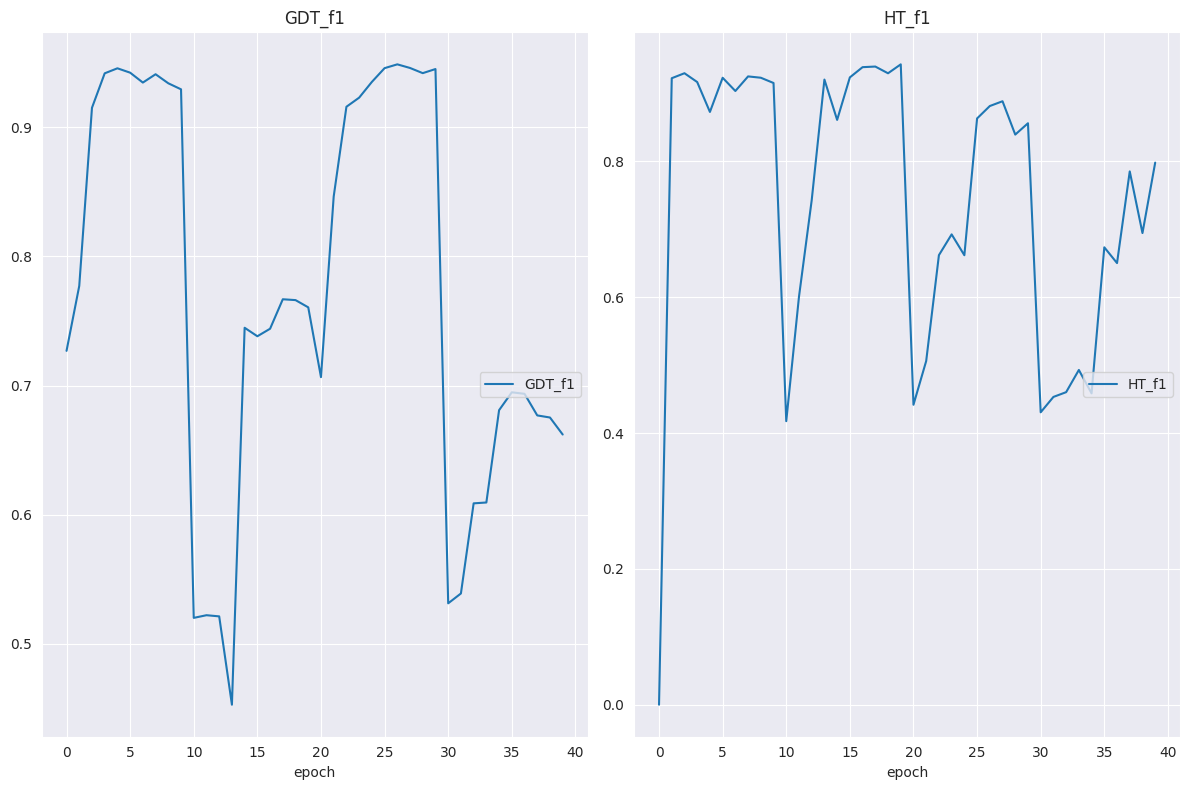

GDT_f1
	GDT_f1           	 (min:    0.453, max:    0.949, cur:    0.662)
HT_f1
	HT_f1            	 (min:    0.000, max:    0.943, cur:    0.798)


In [30]:
from skmultiflow.trees import HoeffdingTreeClassifier
from sklearn.metrics import f1_score
from livelossplot import PlotLosses

classifier = HoeffdingTreeClassifier()

config_training, metrics = prepare_training_for_streams(identifier = 'BIN:agr_a', config = config)
#load Dataset
X_data, y_data, nominal_features, ordinal_features = load_dataset_for_streams(identifier = 'BIN:agr_a')


X_data_stream = np.array_split(X_data, 40)
y_data_stream = np.array_split(y_data, 40)

model_dict = {}
scores_dict = {}

benchmark_dict_HT = {'y_pred':[],
                 'y_valid':[]}
benchmark_dict_GDT = {'y_pred':[],
                 'y_valid':[]}

verbosity = 1

model_dict['GDT'] = GDT(number_of_variables = 5,#dataset_dict['number_of_variables'],
            number_of_classes = 2,#dataset_dict['number_of_classes'],

            objective = config_training['gdt']['objective'],

            depth = config_training['gdt']['depth'],

            learning_rate_index = config_training['gdt']['learning_rate_index'],
            learning_rate_values = config_training['gdt']['learning_rate_values'],
            learning_rate_leaf = config_training['gdt']['learning_rate_leaf'],

            optimizer = config_training['gdt']['optimizer'],

            loss = 'crossentropy',

            initializer_values = config_training['gdt']['initializer_values'],
            initializer_index = config_training['gdt']['initializer_index'],
            initializer_leaf = config_training['gdt']['initializer_leaf'],        

            random_seed = config_training['computation']['random_seed'],
            verbosity = verbosity)  

plotlosses_benchmark = PlotLosses()

for i in range(len(X_data_stream)):
    ((X_train, y_train),
     (X_valid, y_valid),
     (X_test, y_test),
     normalizer_list) = preprocess_data(X_data_stream[i], 
                                       y_data_stream[i],
                                       nominal_features,
                                       ordinal_features,
                                       config_training,
                                       random_seed= 42,#random_seed,
                                       verbosity=1)#verbosity)  
    dataset_dict = {
           'X_train': X_train,
           'y_train': y_train,
           'X_valid': X_valid,
           'y_valid': y_valid,
           'X_test': X_test,
           'y_test': y_test,
           'normalizer_list': normalizer_list
           }

    history = model_dict['GDT'].partial_fit(dataset_dict['X_train'],
              dataset_dict['y_train'],

              batch_size=config_training['gdt']['batch_size'], 
              epochs=config_training['gdt']['epochs'], 

              restarts = 0,#config_test['gdt']['restarts'], 
              #restart_type=config_test['gdt']['restart_type'], 

              #early_stopping_epochs=config_training['gdt']['early_stopping_epochs'], 
              #early_stopping_type=config_test['gdt']['early_stopping_type'],

              valid_data=(dataset_dict['X_valid'],dataset_dict['y_valid']))
    
    
    
    ###EVALUATION
    
    
    
    benchmark_dict_HT['y_test'] =dataset_dict['y_test'].tolist()
    
    temp_X_train =dataset_dict['X_train'].values
    temp_y_train =dataset_dict['y_train'].values
    temp_X_test = dataset_dict['X_test'].values
    
    
    #NEU
    metric = "f1"
    y_test_data = dataset_dict['y_test']
    benchmark_dict_GDT['y_pred'] = model_dict['GDT'].predict(enforce_numpy(temp_X_test))
    benchmark_dict_GDT['y_pred'] = np.nan_to_num(benchmark_dict_GDT['y_pred'])
    y_test = np.round(benchmark_dict_GDT['y_pred'])
    GDT_f1 = sklearn.metrics.get_scorer(metric)._score_func(benchmark_dict_HT['y_test'], y_test, average='weighted')
    
    
    
    #preds_val_metric = model_dict['GDT'].adjust_preds_for_metric(benchmark_dict_HT['y_test'])
    
    #preds_test = model_dict['GDT'].predict(temp_X_test, return_probabilities=True, denormalize=False)#self.forward(valid_data[0], training=False) 
    #metric = tfa.metrics.F1Score(average='weighted', num_classes=model_dict['GDT'].number_of_classes)


    #if True:#self.number_of_classes == 2:
    #    benchmark_dict_GDT['y_pred'] = tf.reduce_mean(metric(np_utils.to_categorical(tf.reshape(benchmark_dict_HT['y_test'], (-1,1)), num_classes=model_dict['GDT'].number_of_classes), 
    #                                                         np_utils.to_categorical(tf.reshape(preds_val_metric, (-1,1)), num_classes=model_dict['GDT'].number_of_classes)))                 
    #else:
    #    benchmark_dict_GDT['y_pred'] = tf.reduce_mean(metric(valid_data[1], preds_val_metric))
    
    #benchmark_dict_GDT['y_pred'] = model_dict['GDT'].predict(temp_X_test)
    
    #Hoeffding tree
    #benchmark_dict['y_valid']= benchmark_dict['y_valid'] + dataset_dict['y_valid'].tolist()

    
    benchmark_dict_HT['y_pred'] = []
    for i in range(0, len(dataset_dict['X_test'])):
        benchmark_dict_HT['y_pred'].append(classifier.predict(np.array([temp_X_test[i]], np.float64))[0])  
    for i in range(0, len(dataset_dict['X_train'])):
        classifier.partial_fit(np.array([temp_X_train[i]], np.float64), np.array([temp_y_train[i]], np.float64))
    
    print("Hoeffding score: " + str(f1_score(benchmark_dict_HT['y_test'],benchmark_dict_HT['y_pred'])))
    VFDT_f1 = f1_score(benchmark_dict_HT['y_test'],benchmark_dict_HT['y_pred'])
    
    plotlosses_benchmark.update({'GDT_f1': GDT_f1,'HT_f1': VFDT_f1})
    plotlosses_benchmark.send() 
    
    
    
    #TODO train und validation zusammenfügen
#'GDT_f1': f1_score(benchmark_dict_HT['y_test'],benchmark_dict_GDT['y_pred'])
    


    #model_dict['sklearn'] = DecisionTreeClassifier(max_depth=config_training['gdt']['depth'], 
     #                                     random_state=config_training['computation']['random_seed'])

    #model_dict['sklearn'].fit(dataset_dict['X_train'], 
    #                          dataset_dict['y_train'])


    # model_dict['GeneticTree'] = GeneticTree()
    # model_dict['GeneticTree'] = model_dict['GeneticTree'].fit(dataset_dict['X_train'].values, 
    #                                                           dataset_dict['y_train'].values)        

    #scores_dict['GDT'] = calculate_scores(model_dict = model_dict, 
     #                              dataset_dict = dataset_dict, 
      #                             scores_dict = prepare_score_dict(config=config_training), 
       #                            metrics = metrics)            

#model.set_params(**config_training['gdt'])   

In [29]:
benchmark_dict_HT['y_test']

[1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0

In [20]:
benchmark_dict_GDT['y_pred']

TypeError: Scalar tensor has no `len()`